<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#compute-the-LODF-matrix" data-toc-modified-id="compute-the-LODF-matrix-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>compute the LODF matrix</a></span></li><li><span><a href="#superposition-theorem-flow-computation" data-toc-modified-id="superposition-theorem-flow-computation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>superposition theorem flow computation</a></span></li><li><span><a href="#Combinations-of-2-actions-of-same-kind" data-toc-modified-id="Combinations-of-2-actions-of-same-kind-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Combinations of 2 actions of same kind</a></span><ul class="toc-item"><li><span><a href="#2-line-disconnections" data-toc-modified-id="2-line-disconnections-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>2 line disconnections</a></span></li><li><span><a href="#2-line-reconnections" data-toc-modified-id="2-line-reconnections-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>2 line reconnections</a></span></li><li><span><a href="#2-node-splitting" data-toc-modified-id="2-node-splitting-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>2 node splitting</a></span></li><li><span><a href="#2-node-merging-actions" data-toc-modified-id="2-node-merging-actions-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>2 node merging actions</a></span></li></ul></li><li><span><a href="#Four-action-combination-with-all-types" data-toc-modified-id="Four-action-combination-with-all-types-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Four action combination with all types</a></span></li></ul></div>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import grid2op
import numpy as np
from lightsim2grid import LightSimBackend
from grid2op.Parameters import Parameters
from superposition_theorem import *
param = Parameters()
param.ENV_DC = True
param.MAX_LINE_STATUS_CHANGED = 99999
param.MAX_SUB_CHANGED = 99999
param.NO_OVERFLOW_DISCONNECTION = True
backend=LightSimBackend()
env = grid2op.make("l2rpn_case14_sandbox", param=param,backend=backend)


In [2]:
chronic_id=0

#if you want to reset the environment on your chronic, always do env.set_id first
env.set_id(chronic_id)
env.reset()

In [3]:
import sys


paths=[i for i in sys.path]


for path in paths:
    sys.path.append(path)

# compute the LODF matrix 

This was the basis for the initial demonstrations. But we directly use the available grid states in the implementation now.

$$\delta_{i,j} = \frac{F_j^{i} - F_j}{F_i}$$

with:
- $\delta_{i,j}$ : "le coefficient de report"
- $F_k$: the active flow on line `k`
- $F_j^{i}$: the flow on line j if the line i is disconnected

We are interested, given all the $\delta_{i,j}$ to compute the $\delta_{\{i,j,k, ...\}, m}$ which are the flows on line `m` when the lines $\{i,j,k, ...\}$ are disconnected

**This is not explicitly needed anymore in our approach**

But is a common data structure used for all other approches such as LODF. So we keep its computation there

In [4]:
_ = env.reset()
#with env.copy() as tmp_env_init:
init_obs, *_ = env.simulate(env.action_space())
F = 1. * init_obs.p_or

In [5]:
init_obs

In [6]:
all_flows = np.zeros((env.n_line, env.n_line))
for l_id in range(env.n_line):
    #with env.copy() as tmp_env:
    obs, *_ = env.simulate(env.action_space({"set_line_status": [(l_id, -1)]}))
    all_flows[l_id, :] = obs.p_or

In [7]:
A = (all_flows - F) / F.reshape(-1, 1)

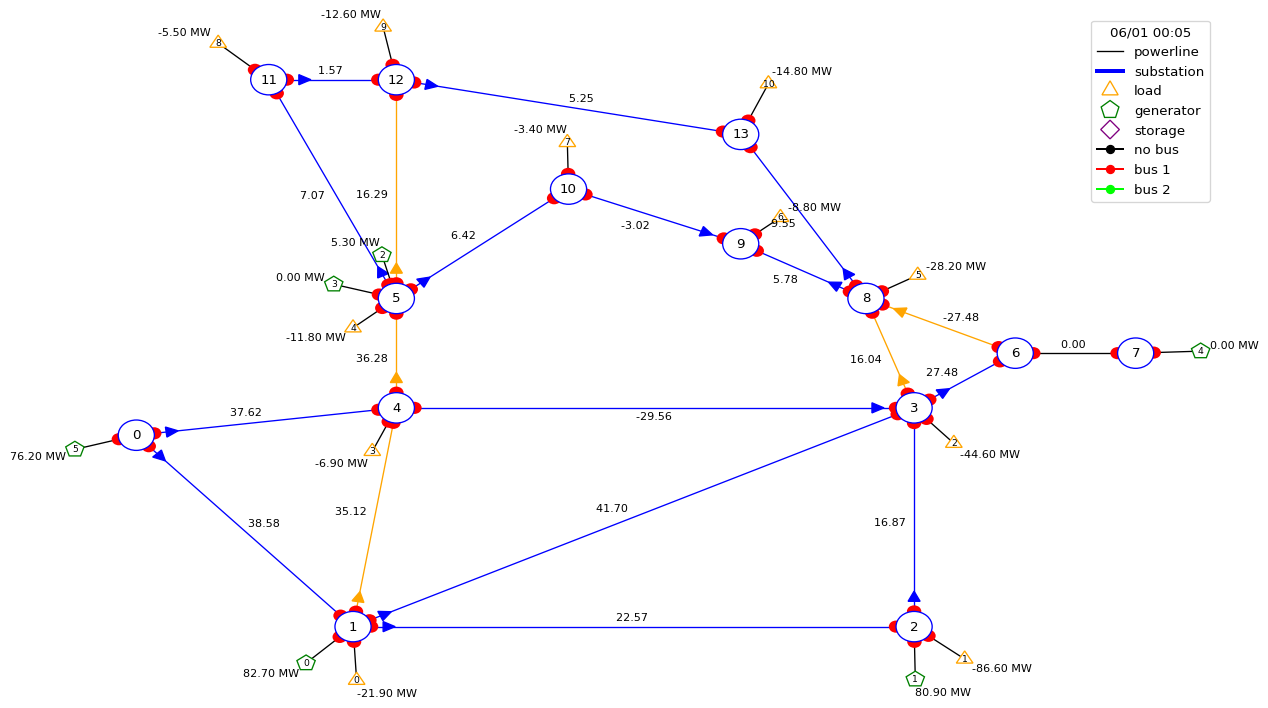

In [8]:
from grid2op.PlotGrid import PlotMatplot
plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_obs(init_obs,line_info="p")
fig.show()


In [9]:
init_obs.p_or

array([ 38.58359  ,  37.61641  ,  22.565678 ,  41.696144 ,  35.121765 ,
        16.86568  , -29.562853 ,   6.4211507,   7.0682087,  16.285961 ,
         5.7788496,   9.545831 ,  -3.0211506,   1.5682089,   5.2541695,
        27.484486 ,  16.040195 ,  36.275322 ,   0.       , -27.484486 ],
      dtype=float32)

# superposition theorem flow computation

Here is the extended superposition theroem for topological changes. The resulting powerflows is a linear combination of unitary change power flows:

\begin{align*}
    PF(T)=\alpha\times PF(T_{ref}) + \beta_1\times PF(T_{ref}\circ \tau_1) + \beta_2\times PF(T_{ref}\circ \tau_2) \\
    \text{with } T=T_{ref} \circ \tau_1 \circ \tau_2  \text{ and } \alpha=1-\beta_1-\beta_2
\end{align*}

We have $T_{ref}$ as the reference topology from which we apply topological changes $\tau_1$ and $\tau_2$ in indifferent order to reach a target topology $T$. Finding the betas simply stems from solving a linear system of dimension the number of considered changes. Only minimal information from individual power flow state is needed for this, without knowledge of any underlying grid properties or complete adjacency matrix.

In [10]:
from superposition_theorem.core.compute_power_flows import compute_flows_superposition_theorem_from_actions, compute_flows_superposition_theorem_from_unit_act_obs
import inspect
from IPython.display import Code

display(Code(inspect.getsource(compute_flows_superposition_theorem_from_unit_act_obs), language='python'))


def compute_flows_superposition_theorem_from_unit_act_obs(idls_lines, idls_subs, obs_start,target_obs, unit_act_observations, check_obs_target=False,
                                        decimal_digit_precision=4):
    """
    Compute the power flows of the combined unitary actions using the superposition theorem of unitary action observations only

    Parameters
    ----------
    idls_lines: `list`:int
        List of grid lines ids corresponding to the elements on which each unitary action intervenesif relevant. Can be empty

    idls_subs: `list`:int
        List of substation ids corresponding to the elements on which each unitary action intervenes if relevant. Can be empty

    obs_start: grid2op.Observation
        base observation to start from

    unit_act_observations: `list`:grid2op.Observation
        List of grid states on which each unitary actions have been applied independently from obs_start

    check_obs_target: `Boolean`
        To assert if the superposition theorem computation was accurate

    decimal_digit_precision: expected number of decimal precision for superposition flow computation compared to load flow

    Returns
    -------
    p_or_combined_action: `np.array` dim n_lines
        The active power flows of the target grid state resulting from the combination of all unitary actions

    """
    n_actions = len(unit_act_observations)
    n_line_actions = len(idls_lines)
    n_sub_actions = len(idls_subs)

    if not n_actions == n_line_actions + n_sub_actions:
        print("There are inconsistencies in your idls: should be either a sub or a line element for each indice.")
        raise ()

    # unit_act_observations
    delta_theta_unit_act_lines = np.array(
        [[get_delta_theta_line(obs_connect_idl, id_lj) for id_lj in idls_lines] for obs_connect_idl in
         unit_act_observations])#[0:n_line_actions]])
    p_or_unit_act_lines = np.array([[obs_connect_idl.p_or[id_lj] for id_lj in idls_lines] for obs_connect_idl in
                                    unit_act_observations])#[0:n_line_actions]])

    # obs_start
    delta_theta_obs_start_lines = np.array([get_delta_theta_line(obs_start, id_lj) for id_lj in idls_lines])
    p_or_obs_start_lines = np.array([obs_start.p_or[id_lj] for id_lj in idls_lines])

    # target_obs
    delta_theta_obs_target_lines = None
    p_or_obs_target_lines = None

    if check_obs_target:
        delta_theta_obs_target_lines = np.array([get_delta_theta_line(target_obs, id_lj) for id_lj in idls_lines])
        p_or_obs_target_lines = np.array([target_obs.p_or[id_lj] for id_lj in idls_lines])

    ###############
    # 2) expand osb_start and unit_act_observations with virtual flows
    if n_sub_actions != 0:
        delta_theta_unit_act_lines_subs, delta_theta_obs_start_lines_subs, delta_theta_obs_target_lines_subs = expand_por_lines_with_sub_virtual_line_delta_theta(
            idls_subs,
            unit_act_observations, obs_start, target_obs,
            delta_theta_unit_act_lines, delta_theta_obs_start_lines, delta_theta_obs_target_lines)

        p_or_unit_act_lines_subs, p_or_obs_start_lines_subs, p_or_obs_target_lines_subs = expand_por_lines_with_sub_virtual_line_flow(
            idls_subs, unit_act_observations,
            obs_start, target_obs,
            p_or_unit_act_lines, p_or_obs_start_lines, p_or_obs_target_lines)
    else:
        delta_theta_unit_act_lines_subs = delta_theta_unit_act_lines
        delta_theta_obs_start_lines_subs = delta_theta_obs_start_lines
        delta_theta_obs_target_lines_subs = delta_theta_obs_target_lines

        p_or_unit_act_lines_subs = p_or_unit_act_lines
        p_or_obs_start_lines_subs = p_or_obs_start_lines
        p_or_obs_target_lines_subs = p_or_obs_target_lines

    # compute the betas
    idls = idls_lines + idls_subs
    betas = get_betas_coeff_N_unit_acts_ultimate(delta_theta_unit_act_lines_subs,
                                                            delta_theta_obs_start_lines_subs,
   

This relies on the computation of beta coefficients from this function

In [11]:
from superposition_theorem.core.compute_beta_coefficients import get_betas_coeff_N_unit_acts_ultimate
display(Code(inspect.getsource(get_betas_coeff_N_unit_acts_ultimate), language='python'))


def get_betas_coeff_N_unit_acts_ultimate(delta_theta_connect_idls ,delta_theta_obs_start ,p_or_connect_idls
                                         ,p_or_obs_start ,delta_theta_obs_target=None ,p_or_obs_target=None ,idls=None):

    """
        Compute the coefficients to apply the superposition theorem with each unitary action of any kind,
        using p_or for disconnect or split actions, or delta_thetas for reconnect or merge action

        Parameters
        ----------
        idls: :class:`list`, dtype:pair(int,int)
            List of grid lines or "virtual" lines corresponding to the elements on which each unitary action intervenes.
            The pair is the ids of each extremity node
        delta_theta_connect_idls: :class:`numpy.ndarray`, dtype:float64
            array of dim n_unitary_actions*n_unitary_actions. For each observation of unitary action intervention,
            it records the delta theta elemnts of every grid lines or "virtual lines" on which any considered unitary action could intervene
        delta_theta_obs_start: :class:`numpy.ndarray`, dtype:float64
             array of dim n_unitary_actions. For the base observation without any action,
             it records the delta theta elements of every grid lines or "virtual lines" on which any considered unitary action could intervene
        p_or_connect_idls: :class:`numpy.ndarray`, dtype:float64
            array of dim n_unitary_actions*n_unitary_actions. For each observation of unitary action intervention,
            it records the p_or elements of every grid lines or "virtual lines" on which any considered unitary action could intervene
        p_or_obs_start: :class:`numpy.ndarray`, dtype:float64
            array of dim n_unitary_actions. For the base observation without any action,
            it records the p_or elements of every grid lines or "virtual lines" on which any considered unitary action could intervene
        delta_theta_obs_target: :class:`numpy.ndarray`, dtype:float64
            array of dim n_unitary_actions. If computed for live assert of proper computation, for the target observation with all combined actions,
            it records the delta theta elements of every grid lines or "virtual lines" on which any considered unitary action could intervene
        p_or_obs_target: :class:`numpy.ndarray`, dtype:float64`
            array of dim n_unitary_actions. If computed for live assert of proper computation, for the target observation with all combined actions,
            it records the p_or elements of every grid lines or "virtual lines" on which any considered unitary action could intervene

        Returns
        -------
        betas: :class:`numpy.ndarray`, dtype:float64
            the superposition theorem coefficient value to assign to each observation of unitary action intervention

        """



    if (p_or_obs_target is not None) and (delta_theta_obs_target is not None):
        expected_betas =[p_or_obs_target[i ] /p_or_connect_idls[i][i] if
                    ((p_or_connect_idls[i][i] != 0) and (p_or_obs_target[i])) else
                          delta_theta_obs_target[i] / delta_theta_connect_idls[i][i] for i, id_l in enumerate(idls)]
        print("expected_betas :" + str(expected_betas))

    n_lines_connect = len(idls)

    a = np.array([[1 - p_or_connect_idls[i][j] / p_or_obs_start[j] if (
                (p_or_connect_idls[i][j] != 0) and (p_or_obs_start[j])) else
                   1 - delta_theta_connect_idls[i][j] / delta_theta_obs_start[j] \
                   for i in range(len(idls))] for j in range(len(idls))])

    np.fill_diagonal(a, 1)

    b = np.ones(n_lines_connect)

    print(a)
    print(b)

    betas = np.linalg.solve(a, b)

    print("computed betas: " + str(betas))

    return betas

# Combinations of 2 actions of same kind

Notice: You can look at the tests of the package for extensive combinatorial use cases, and for getting a better grasp on the code

In [12]:
chronic_id = 0
decimal_accuracy = 4 # when assessing the accuracy of the superposition theorem computation compared to a full load flow computation

## 2 line disconnections

compute the beta coefficients, compared to what betas are expected in the case we already know the target flows

In [18]:
env.set_id(chronic_id)
env.reset()

id_l1 = 3  # 1#2#3
id_l2 = 7  # 2#4#7
unitary_action_list = [{"set_line_status": [(id_l1, -1)]},  # sub5
                       {"set_line_status": [(id_l2, -1)]},  # sub4
                       ]


obs_start, *_  = env.step(env.action_space({}))

unitary_actions = [env.action_space(unitary_act) for unitary_act in unitary_action_list]

# computing obs_target load flow with the effect of combined action: this is the ground truth to compare to

combined_action = unitary_actions[0] + unitary_actions[1]
obs_target = obs_start.simulate(combined_action, time_step=0)[0]

print("computation time for target state load flow was "+str(obs_target._obs_env.backend._timer_solver)+" s")


computation time for target state load flow was 0.0009223340166499838 s


initial state with lines disconnected to reconnect


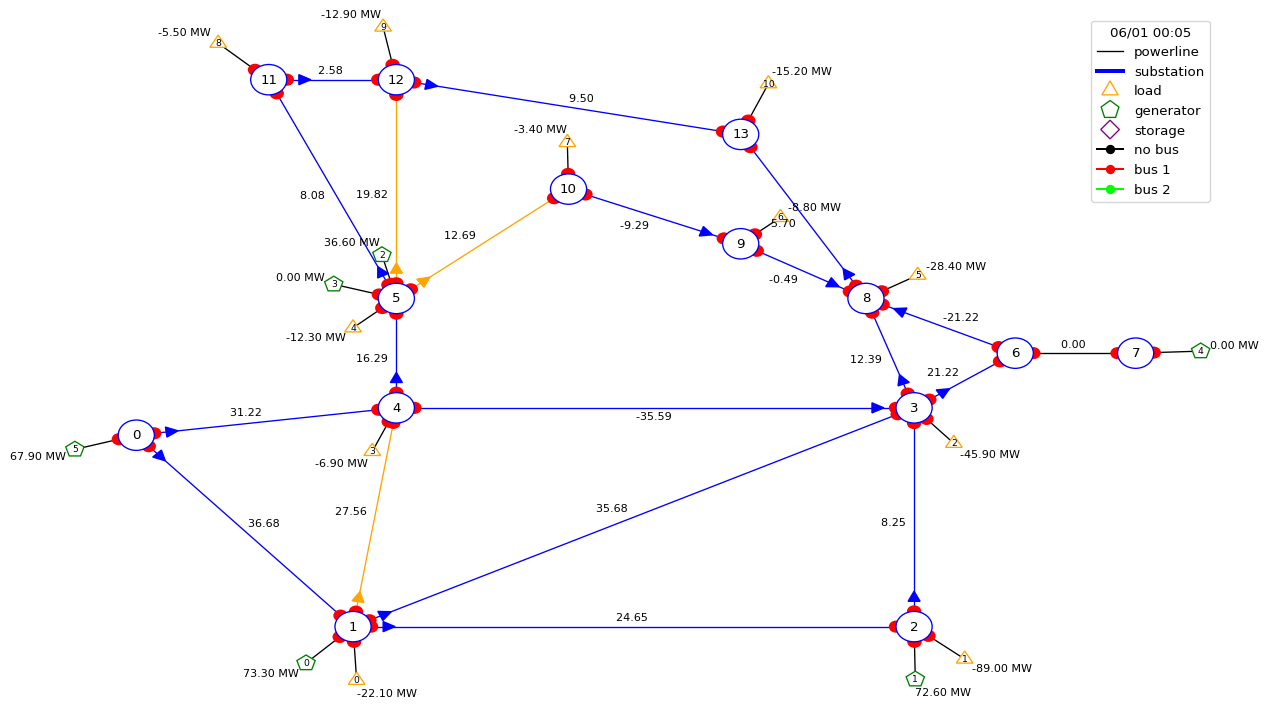

In [19]:
print("initial state with lines disconnected to reconnect")
fig = plot_helper.plot_obs(obs_start,line_info="p")
fig.show()

final state with lines reconnected


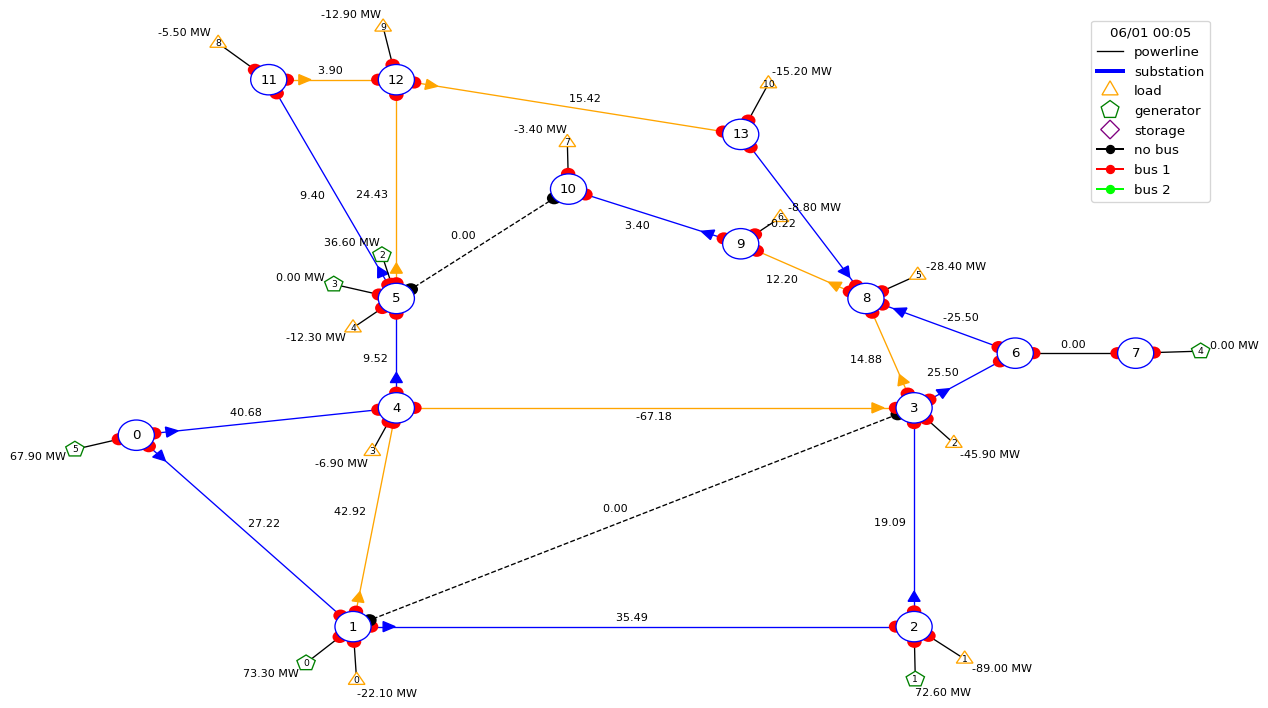

In [20]:
print("final state with lines reconnected")
fig = plot_helper.plot_obs(obs_target,line_info="p")
fig.show()

"All by hand"

In [21]:
# computing intermediate states in which we applied one unitary action
from time import perf_counter

obs1 = obs_start.simulate(unitary_actions[0], time_step=0)[0]
obs2 = obs_start.simulate(unitary_actions[1], time_step=0)[0]

# solving the linear system by "hand" and computing the superposition
t_start=perf_counter()
a = np.array([[1, 1 - obs2.p_or[id_l1] / obs_start.p_or[id_l1]],
              [1 - obs1.p_or[id_l2] / obs_start.p_or[id_l2], 1]])

b = np.ones(2)
betas = np.linalg.solve(a, b)

p_target_computed = betas[0] * obs1.p_or + betas[1] * obs2.p_or + (1 - betas.sum()) * obs_start.p_or
t_end=perf_counter()
print("sup th computation time was: "+str(t_end-t_start)+" s")

print("beta coefficients are: "+str(betas))

assert (np.all((np.round(obs_target.p_or - p_target_computed,decimal_accuracy ) == 0.0)))

print(p_target_computed)


sup th computation time was: 0.00045886200678069144 s
beta coefficients are: [1.02436805 1.0685074 ]
[ 27.21719     40.682816    35.49418      0.          42.92301
  19.094173   -67.181305     0.           9.3959675   24.428553
  12.199999    -0.22452211   3.3999996    3.8959658   15.424521
  25.495861    14.879616     9.524525     0.         -25.495861  ]


Or you could have directly computed the resulting flows with the superposition theorem


In [22]:
idls_subs=[]
idls_lines = [id_l1,id_l2]
unit_act_observations = [obs1,obs2]

compute_flows_superposition_theorem_from_unit_act_obs(idls_lines, idls_subs, obs_start,obs_target, unit_act_observations, check_obs_target=False,
                                        decimal_digit_precision=4)

[[ 1.         -0.02280569]
 [-0.06687772  1.        ]]
[1. 1.]
computed betas: [1.02436805 1.0685074 ]


array([ 27.217192  ,  40.68281   ,  35.494175  ,   0.        ,
        42.92301   ,  19.094173  , -67.181305  ,   0.        ,
         9.3959675 ,  24.428555  ,  12.199999  ,  -0.22452217,
         3.3999999 ,   3.895966  ,  15.424522  ,  25.49586   ,
        14.879617  ,   9.524524  ,   0.        , -25.49586   ],
      dtype=float32)

## 2 line reconnections

compute the beta coefficients, compared to what betas are expected in the case we already know the target flows

In [34]:
from superposition_theorem.core.compute_power_flows import get_delta_theta_line

env.set_id(chronic_id)
env.reset()

id_l1 = 3  # 1#2#3
id_l2 = 7  # 2#4#7
unitary_action_list = [{"set_line_status": [(id_l1, +1)]},  # sub5
                       {"set_line_status": [(id_l2, +1)]},  # sub4
                       ]

# need ooposite list of actions to start with an observation where those lines are disconnected
opposite_action_list = [{"set_line_status": [(id_l1, -1)]},
                        {"set_line_status": [(id_l2, -1)]}]

combined_opposite_action = env.action_space(opposite_action_list[0])+env.action_space(opposite_action_list[1])
obs_start, *_  = env.step(combined_opposite_action)

unitary_actions = [env.action_space(unitary_act) for unitary_act in unitary_action_list]

# computing obs_target load flow with the effect of combined action: this is the ground truth to compare to

combined_action = unitary_actions[0] + unitary_actions[1]
obs_target = obs_start.simulate(combined_action, time_step=0)[0]

com_time_solver=obs_target._obs_env.backend._timer_solver
print("computation time for target state load flow was "+str(com_time_solver)+" s")


computation time for target state load flow was 0.0017147069884231314 s


initial state with lines disconnected to reconnect


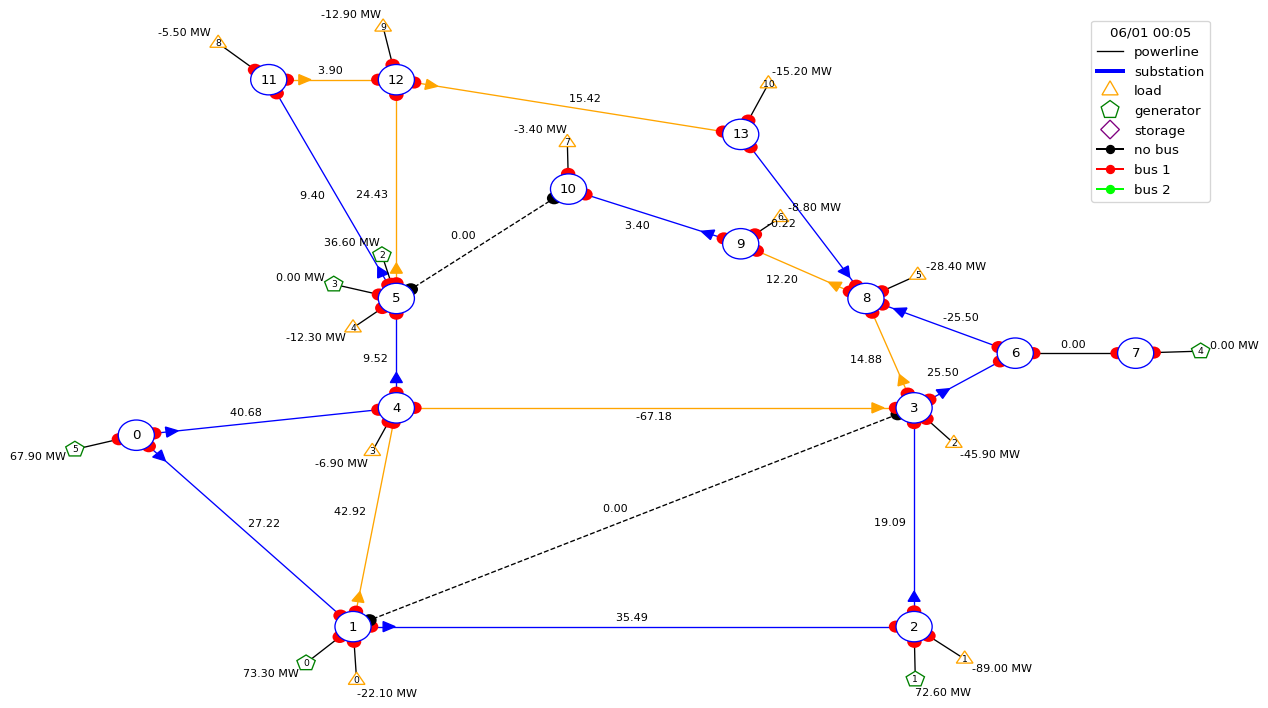

In [31]:
print("initial state with lines disconnected to reconnect")
fig = plot_helper.plot_obs(obs_start,line_info="p")
fig.show()

final state with lines reconnected


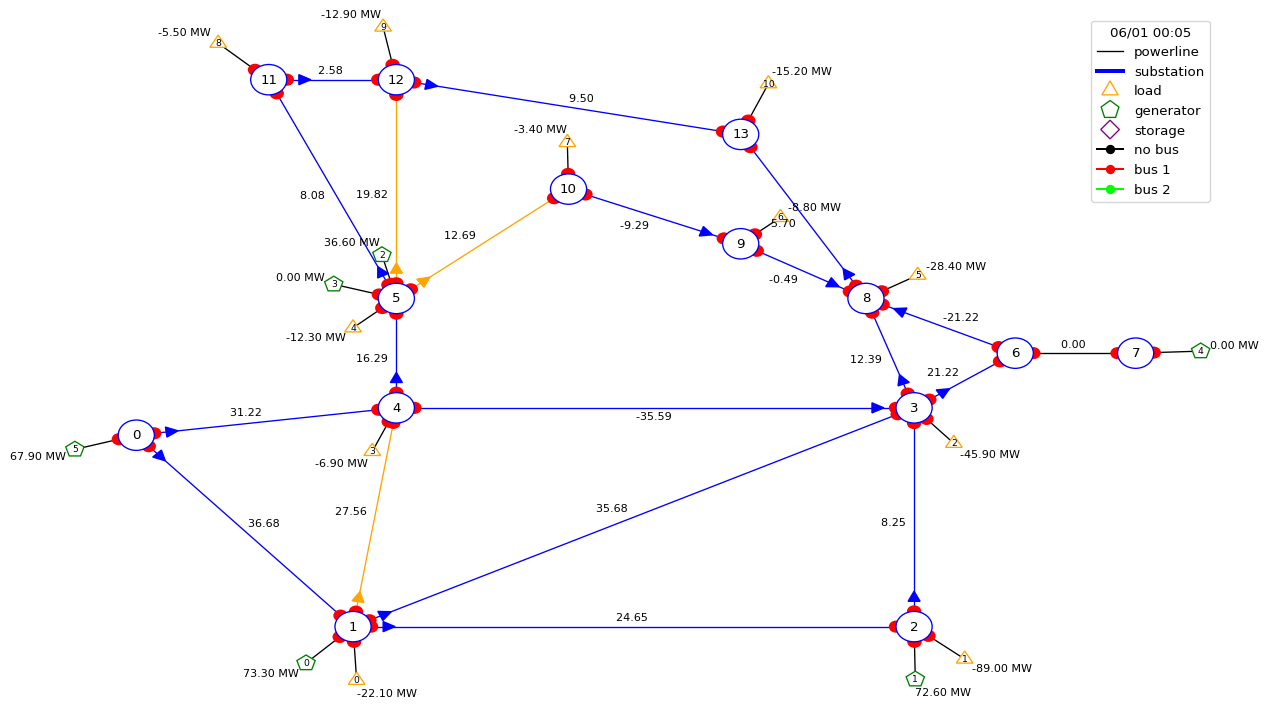

In [32]:
print("final state with lines reconnected")
fig = plot_helper.plot_obs(obs_target,line_info="p")
fig.show()

"All by hand"

In [36]:
# computing intermediate states in which we applied one unitary action

obs1 = obs_start.simulate(unitary_actions[0], time_step=0)[0]
obs2 = obs_start.simulate(unitary_actions[1], time_step=0)[0]

delta_theta_l1_obs2=get_delta_theta_line(obs2, id_l1)
delta_theta_l1_obs_start=get_delta_theta_line(obs_start, id_l1)
delta_theta_l2_obs1=get_delta_theta_line(obs1, id_l2)
delta_theta_l2_obs_start=get_delta_theta_line(obs_start, id_l2)

# solving the linear system by "hand" and computing the superposition
t_start=perf_counter()
a = np.array([[1, 1 - delta_theta_l1_obs2 / delta_theta_l1_obs_start],
              [1 -  delta_theta_l2_obs1 / delta_theta_l2_obs_start, 1]])

b = np.ones(2)
betas = np.linalg.solve(a, b)

p_target_computed = betas[0] * obs1.p_or + betas[1] * obs2.p_or + (1 - betas.sum()) * obs_start.p_or
t_end=perf_counter()

com_time_sup_th=t_end-t_start
print("sup th computation time was: "+str(com_time_sup_th)+" s")
print("this is a speed-up factor of "+str(np.round(com_time_solver/com_time_sup_th,1))+" compared to solver")

print("beta coefficients are: "+str(betas))

assert (np.all((np.round(obs_target.p_or - p_target_computed,decimal_accuracy ) == 0.0)))

print(p_target_computed)


sup th computation time was: 0.00016844298806972802 s
this is a speed-up factor of 10.2 compared to solver
beta coefficients are: [0.97770274 0.9373146 ]
[ 36.6837      31.216305    24.648632    35.676342    27.558727
   8.248627   -35.58635     12.68699      8.079209    19.822481
  -0.48698997   5.6983104   -9.286989     2.5792086    9.501689
  21.224503    12.386815    16.28868      0.         -21.224503  ]


You could have computed the betas with this function

In [26]:
idls_lines = [id_l1,id_l2]
unit_act_observations = [obs1,obs2]

# getting delta thetas and ative power flows
delta_theta_unit_act_lines = np.array(
    [[get_delta_theta_line(obs_connect_idl, id_lj) for id_lj in idls_lines] for obs_connect_idl in
     unit_act_observations])

p_or_unit_act_lines = np.array([[obs_connect_idl.p_or[id_lj] for id_lj in idls_lines] for obs_connect_idl in
                                    unit_act_observations])#[0:n_line_actions]])

# obs_start
delta_theta_obs_start_lines = np.array([get_delta_theta_line(obs_start, id_lj) for id_lj in idls_lines])
p_or_obs_start_lines = np.array([obs_start.p_or[id_lj] for id_lj in idls_lines])


betas=get_betas_coeff_N_unit_acts_ultimate(delta_theta_unit_act_lines ,delta_theta_obs_start_lines ,p_or_unit_act_lines
                                         ,p_or_obs_start_lines ,delta_theta_obs_target=None ,p_or_obs_target=None ,idls=idls_lines)



[[1.         0.02378845]
 [0.06411499 1.        ]]
[1. 1.]
computed betas: [0.97770274 0.9373146 ]


Or you could have directly computed the resulting flows with the superposition theorem


In [29]:
idls_subs=[]
compute_flows_superposition_theorem_from_unit_act_obs(idls_lines, idls_subs, obs_start,obs_target, unit_act_observations, check_obs_target=False,
                                        decimal_digit_precision=4)

[[1.         0.02378845]
 [0.06411499 1.        ]]
[1. 1.]
computed betas: [0.97770274 0.9373146 ]


array([ 3.6683697e+01,  3.1216307e+01,  2.4648630e+01,  3.5676342e+01,
        2.7558727e+01,  8.2486277e+00, -3.5586353e+01,  1.2686990e+01,
        8.0792103e+00,  1.9822479e+01, -4.8698974e-01,  5.6983104e+00,
       -9.2869892e+00,  2.5792086e+00,  9.5016899e+00,  2.1224504e+01,
        1.2386815e+01,  1.6288681e+01,  1.0158734e-14, -2.1224504e+01],
      dtype=float32)

## 2 node splitting

compute the beta coefficients, compared to what betas are expected in the case we already know the target flows

In [46]:
env.set_id(chronic_id)
env.reset()

id_sub1 = 5  
id_sub2 = 4  
unitary_action_list = [{'set_bus': {'substations_id': [(5, (1, 1, 2, 2, 1, 2, 2))]}},  # sub5
                       {'set_bus': {'substations_id': [(4, (2, 1, 2, 1, 2))]}},  # sub4
                       ]


obs_start, *_  = env.step(env.action_space({}))

unitary_actions = [env.action_space(unitary_act) for unitary_act in unitary_action_list]

# computing obs_target load flow with the effect of combined action: this is the ground truth to compare to

combined_action = unitary_actions[0] + unitary_actions[1]
obs_target = obs_start.simulate(combined_action, time_step=0)[0]

com_time_solver=obs_target._obs_env.backend._timer_solver
print("computation time for target state load flow was "+str(com_time_solver)+" s")

computation time for target state load flow was 0.0027699410275090486 s


initial state with lines disconnected to reconnect


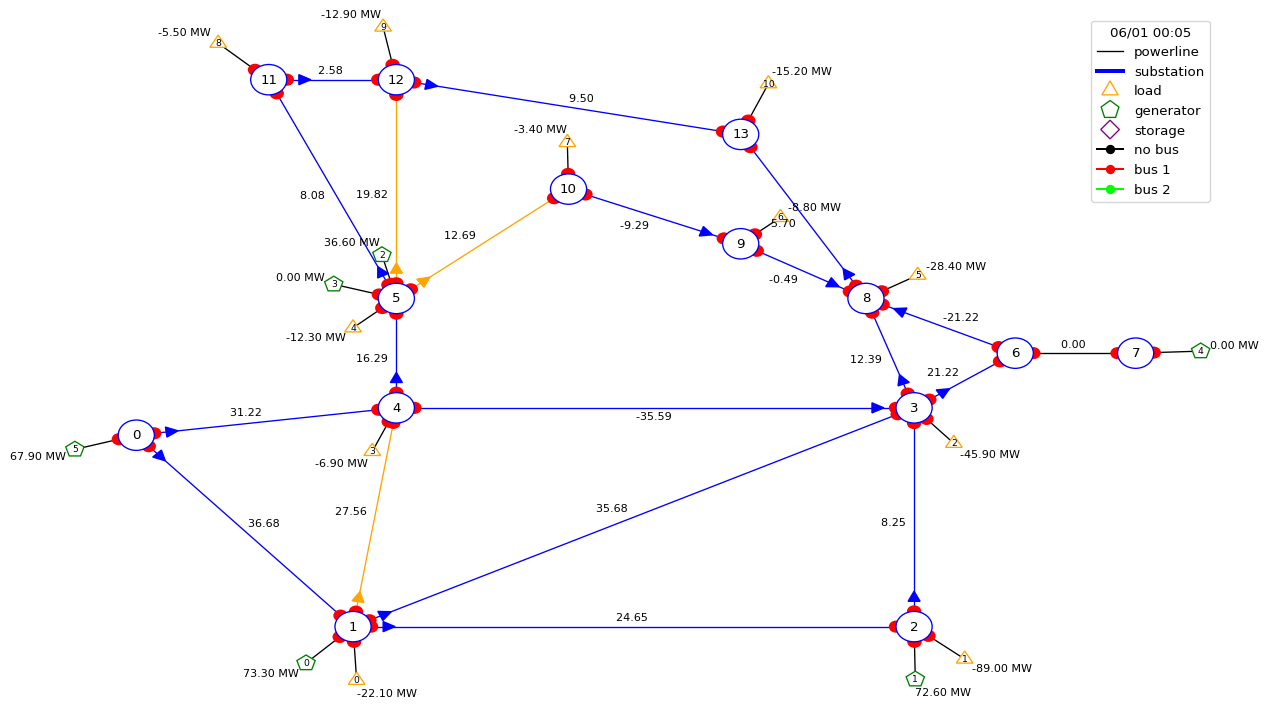

In [47]:
print("initial state with lines disconnected to reconnect")
fig = plot_helper.plot_obs(obs_start,line_info="p")
fig.show()

final state with lines reconnected


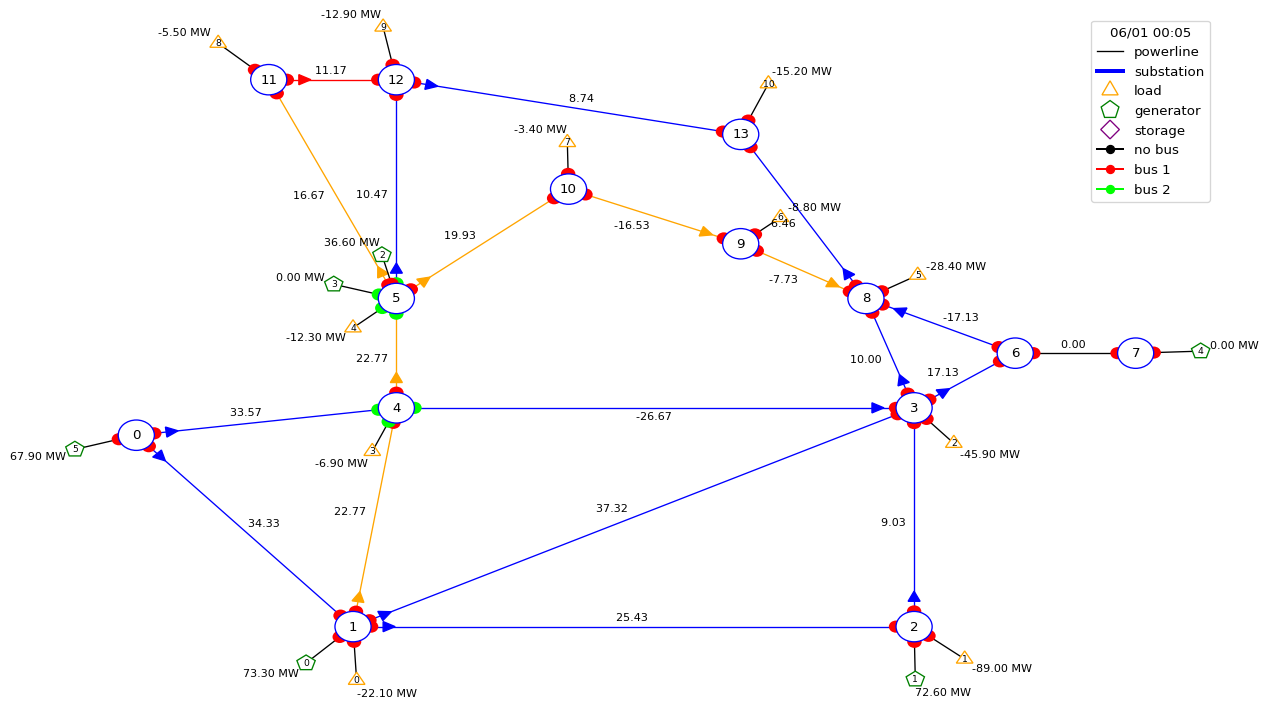

In [48]:
print("final state with lines reconnected")
fig = plot_helper.plot_obs(obs_target,line_info="p")
fig.show()

"All by hand"

In [49]:
from superposition_theorem.core.compute_power_flows import get_sub_node1_idsflow,get_virtual_line_flow
# computing intermediate states in which we applied one unitary action

obs1 = obs_start.simulate(unitary_actions[0], time_step=0)[0]
obs2 = obs_start.simulate(unitary_actions[1], time_step=0)[0]

(ind_load_node1_sub1, ind_prod_node1_sub1, ind_lor_node1_sub1, ind_lex_node1_sub1) = get_sub_node1_idsflow(obs1,
                                                                                                           id_sub1)
(ind_load_node1_sub2, ind_prod_node1_sub2, ind_lor_node1_sub2, ind_lex_node1_sub2) = get_sub_node1_idsflow(obs2,
                                                                                                           id_sub2)

# virtual line flows: this is not directly computed by the load flow solver.
# you need to recover the ids of the element of one of the that will appear after splitting
# and compute the imbalance of flows for these elements before the substation gets split:
# this gives the equivalent of virtual line flows between the two nodes that will appear

t_start=perf_counter()# starts here as virtual line flow needs to be computed in this case as not directly available from state

p_start_sub1 = get_virtual_line_flow(obs_start, ind_load_node1_sub1, ind_prod_node1_sub1, ind_lor_node1_sub1,
                                     ind_lex_node1_sub1)
p_start_sub2 = get_virtual_line_flow(obs_start, ind_load_node1_sub2, ind_prod_node1_sub2, ind_lor_node1_sub2,
                                     ind_lex_node1_sub2)

p_obs1_sub2 = get_virtual_line_flow(obs1, ind_load_node1_sub2, ind_prod_node1_sub2, ind_lor_node1_sub2,
                                    ind_lex_node1_sub2)

p_obs2_sub1 = get_virtual_line_flow(obs2, ind_load_node1_sub1, ind_prod_node1_sub1, ind_lor_node1_sub1,
                                    ind_lex_node1_sub1)

# solving the linear system by "hand" and computing the superposition

a = np.array([[1, 1 - p_obs2_sub1 / p_start_sub1],
              [1 - p_obs1_sub2 / p_start_sub2, 1]])

b = np.ones(2)
betas = np.linalg.solve(a, b)

p_target_computed = betas[0] * obs1.p_or + betas[1] * obs2.p_or + (1 - betas.sum()) * obs_start.p_or

t_end=perf_counter()

com_time_sup_th=t_end-t_start
print("sup th computation time was: "+str(com_time_sup_th)+" s")
print("this is a speed-up factor of "+str(np.round(com_time_solver/com_time_sup_th,1))+" compared to solver")

assert (np.all((np.round(obs_target.p_or - p_target_computed,decimal_accuracy ) == 0.0)))

print(p_target_computed)


sup th computation time was: 0.0004260120040271431 s
this is a speed-up factor of 6.5 compared to solver
[ 34.326584   33.573414   25.434204   37.320374   22.772003    9.034202
 -26.673416   19.930716   16.669277   10.472005   -7.730717    6.4587126
 -16.530718   11.169279    8.741287   17.130486    9.997507   22.772005
   0.        -17.130486 ]


Or you could have directly computed the resulting flows with the superposition theorem


In [50]:
idls_subs=[id_sub1,id_sub2]
idls_lines = []
unit_act_observations = [obs1,obs2]

compute_flows_superposition_theorem_from_unit_act_obs(idls_lines, idls_subs, obs_start,obs_target, unit_act_observations, check_obs_target=False,
                                        decimal_digit_precision=4)

expected_betas :[0.9219016390501895, 0.6239378580421809]
[[1.         0.12517009]
 [0.40791978 1.        ]]
[1. 1.]
computed betas: [0.92190161 0.6239381 ]


array([ 34.326584 ,  33.573414 ,  25.434204 ,  37.320374 ,  22.772007 ,
         9.034202 , -26.673416 ,  19.930716 ,  16.66928  ,  10.472005 ,
        -7.7307177,   6.4587126, -16.530716 ,  11.169279 ,   8.741287 ,
        17.130486 ,   9.997507 ,  22.772005 ,   0.       , -17.130486 ],
      dtype=float32)

## 2 node merging actions

compute the beta coefficients, compared to what betas are expected in the case we already know the target flows

In [53]:
env.set_id(chronic_id)
env.reset()

id_sub1 = 5  
id_sub2 = 4  

unitary_action_list = [{'set_bus': {'substations_id': [(5, (1, 1, 1, 1, 1, 1, 1))]}},  # sub5
                       {'set_bus': {'substations_id': [(4, (1, 1, 1, 1, 1))]}},  # sub4
                       ]

# need ooposite list of actions to start with an observation where those lines are disconnected
opposite_action_list = [{'set_bus': {'substations_id': [(5, (1, 1, 2, 2, 1, 2, 2))]}},  # sub5
                       {'set_bus': {'substations_id': [(4, (2, 1, 2, 1, 2))]}},  # sub4
                       ]

combined_opposite_action = env.action_space(opposite_action_list[0])+env.action_space(opposite_action_list[1])
obs_start, *_  = env.step(combined_opposite_action)

unitary_actions = [env.action_space(unitary_act) for unitary_act in unitary_action_list]

# computing obs_target load flow with the effect of combined action: this is the ground truth to compare to

combined_action = unitary_actions[0] + unitary_actions[1]
obs_target = obs_start.simulate(combined_action, time_step=0)[0]

com_time_solver=obs_target._obs_env.backend._timer_solver
print("computation time for target state load flow was "+str(com_time_solver)+" s")

computation time for target state load flow was 0.002922597006545402 s


initial state with lines disconnected to reconnect


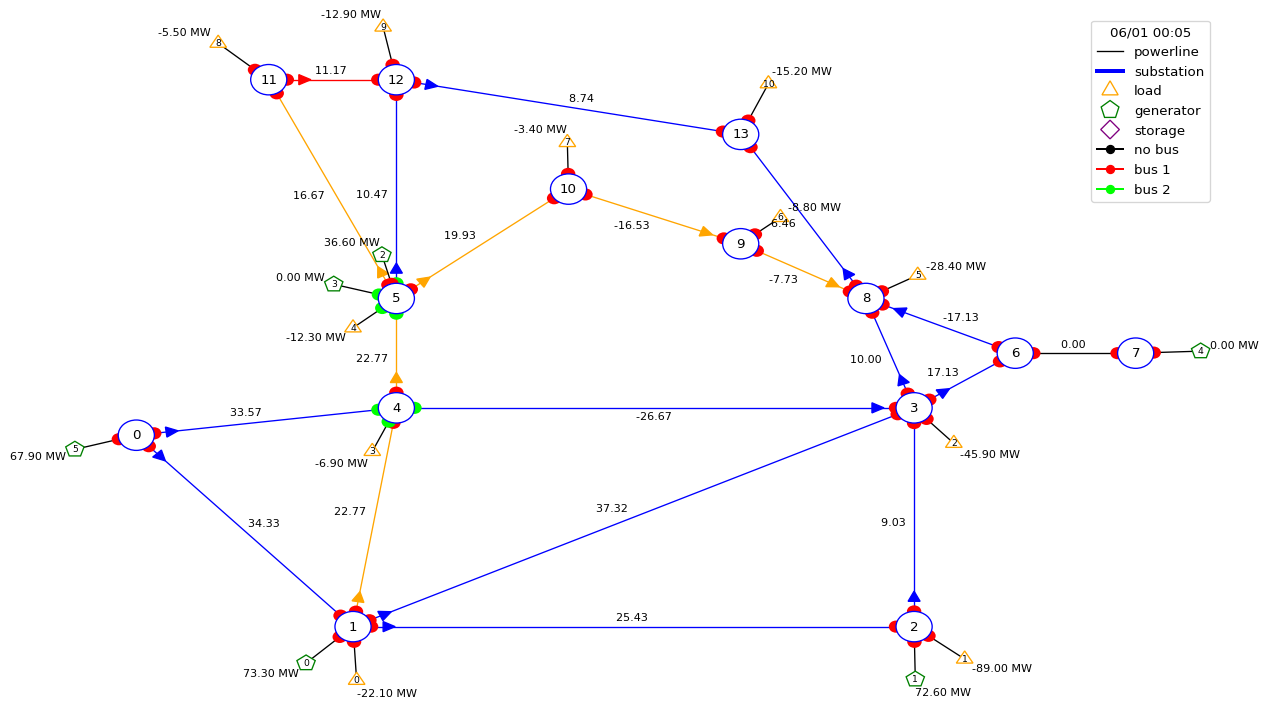

In [54]:
print("initial state with lines disconnected to reconnect")
fig = plot_helper.plot_obs(obs_start,line_info="p")
fig.show()

final state with lines reconnected


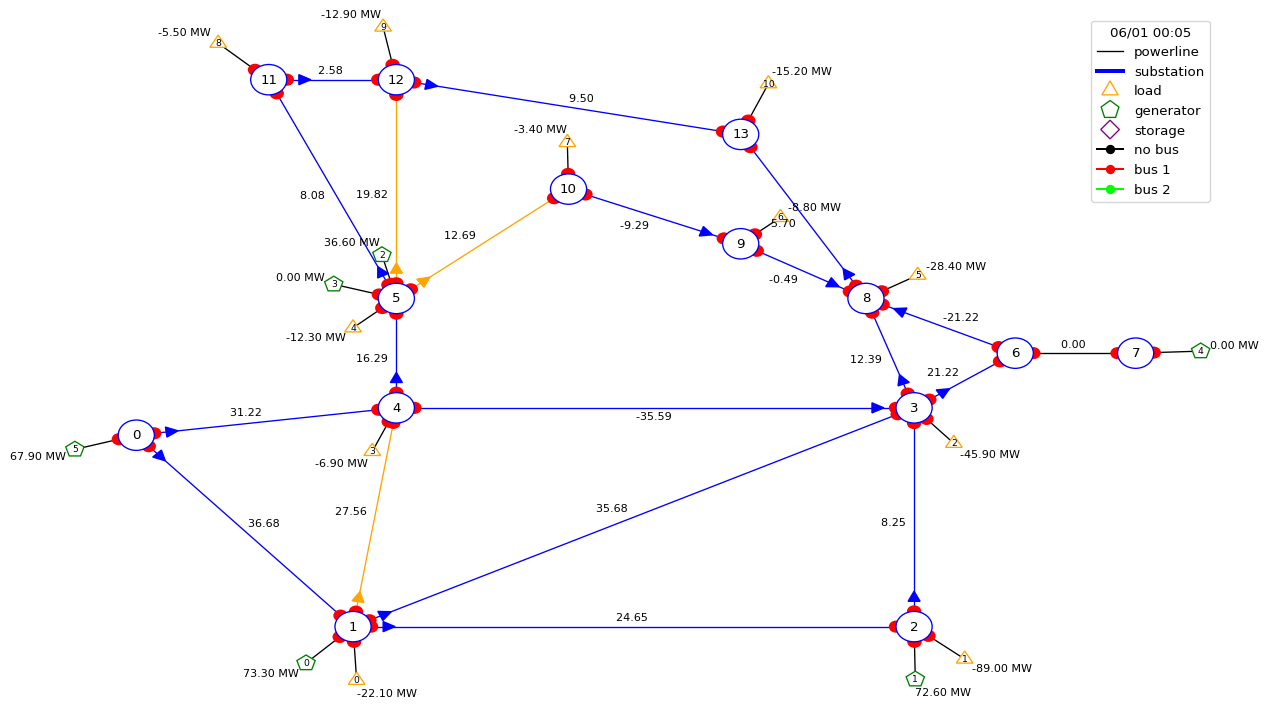

In [55]:
print("final state with lines reconnected")
fig = plot_helper.plot_obs(obs_target,line_info="p")
fig.show()

"All by hand"

In [58]:
from superposition_theorem.core.compute_power_flows import get_delta_theta_sub_2nodes
# computing intermediate states in which we applied one unitary action

obs1 = obs_start.simulate(unitary_actions[0], time_step=0)[0]
obs2 = obs_start.simulate(unitary_actions[1], time_step=0)[0]

# computing delta thetas at a substation between nodes split
delta_theta_sub1_obs2 = get_delta_theta_sub_2nodes(obs2,id_sub1)
delta_theta_sub1_obs_start = get_delta_theta_sub_2nodes(obs_start, id_sub1)

delta_theta_sub2_obs1 = get_delta_theta_sub_2nodes(obs1,id_sub2)
delta_theta_sub2_obs_start = get_delta_theta_sub_2nodes(obs_start, id_sub2)

# solving the linear system by "hand" and computing the superposition
t_start=perf_counter()
a = np.array([[1, 1 - delta_theta_sub1_obs2 / delta_theta_sub1_obs_start],
                      [1 - delta_theta_sub2_obs1 / delta_theta_sub2_obs_start, 1]])

b = np.ones(2)
betas = np.linalg.solve(a, b)

p_target_computed = betas[0] * obs1.p_or + betas[1] * obs2.p_or + (1 - betas.sum()) * obs_start.p_or

t_end=perf_counter()

com_time_sup_th=t_end-t_start
print("sup th computation time was: "+str(com_time_sup_th)+" s")
print("this is a speed-up factor of "+str(np.round(com_time_solver/com_time_sup_th,1))+" compared to solver")

assert (np.all((np.round(obs_target.p_or - p_target_computed,decimal_accuracy ) == 0.0)))

print(p_target_computed)


sup th computation time was: 0.00017216199194081128 s
this is a speed-up factor of 17.0 compared to solver
[ 36.683693   31.216309   24.648628   35.676346   27.558731    8.248629
 -35.58636    12.686985    8.079206   19.822477   -0.4869871   5.698311
  -9.286987    2.5792103   9.50169    21.224508   12.386812   16.288677
   0.        -21.224508 ]


Or you could have directly computed the resulting flows with the superposition theorem


In [65]:
idls_subs=[id_sub1,id_sub2]
idls_lines = []
unit_act_observations = [obs1,obs2]

compute_flows_superposition_theorem_from_unit_act_obs(idls_lines, idls_subs, obs_start,obs_target, unit_act_observations, check_obs_target=False,
                                        decimal_digit_precision=4)

expected_betas :[nan, 0.2]
[[ 1.         -0.08471442]
 [-0.60272371  1.        ]]
[1. 1.]
computed betas: [1.14307935 1.68896103]


array([ 3.66836967e+01,  3.12163086e+01,  2.46486320e+01,  3.56763458e+01,
        2.75587273e+01,  8.24862766e+00, -3.55863571e+01,  1.26869850e+01,
        8.07920647e+00,  1.98224773e+01, -4.86987114e-01,  5.69831133e+00,
       -9.28698730e+00,  2.57921028e+00,  9.50168991e+00,  2.12245064e+01,
        1.23868132e+01,  1.62886772e+01, -1.26907304e-14, -2.12245064e+01],
      dtype=float32)

# Four action combination with all types

Initial state starts with one substation with node splitting on which we apply merging, and one line disconnected that we will reconnect.

Conversely we will split nodes at another substation and disconnect another line

WARNING: be careful if you do a line action and substation action that belongs to the same substation, Grid2op might return that it is an ambiguous action and don't play them.

In [59]:
env.set_id(chronic_id)
env.reset()

#be careful with ambiguous actions when combining actions on lines and substations such as
#Grid2OpException AmbiguousAction InvalidLineStatus InvalidLineStatus('You ask to disconnect a powerline but also to connect it to a certain bus.')

id_l1 = 3  # 1#2#3
id_l2 = 2  # 2#4#7
id_sub1 = 5
id_sub2 = 4
idls_lines = [id_l1,id_l2]
idls_subs = [id_sub1, id_sub2]

unitary_action_list = [{"set_line_status": [(id_l1, +1)]},  # reconnection
                       {"set_line_status": [(id_l2, -1)]}, # disconnection
                       {'set_bus': {'substations_id': [(5, (1, 1, 1, 1, 1, 1, 1))]}},  # merging
                       {'set_bus': {'substations_id': [(4, (2, 1, 2, 1, 2))]}},  # splitting
                       ]

# need ooposite list of actions to start with an observation where those lines are disconnected
opposite_action_list = [{"set_line_status": [(id_l1, -1)]},
                        {"set_line_status": [(id_l2, +1)]},
                        {'set_bus': {'substations_id': [(5, (1, 1, 2, 2, 1, 2, 2))]}},
                        {'set_bus': {'substations_id': [(4, (1, 1, 1, 1, 1))]}},
                        ]

combined_opposite_action=env.action_space({})
for unit_act in opposite_action_list:
    combined_opposite_action+=env.action_space(unit_act)
obs_start, *_ = env.step(combined_opposite_action)

unitary_actions = [env.action_space(unitary_act) for unitary_act in unitary_action_list]

# computing obs_target load flow with the effect of combined action: this is the ground truth to compare to

n_actions = len(unitary_actions)
combined_action = unitary_actions[0]
for i in range(1, n_actions):
    combined_action += unitary_actions[i]
obs_target, *_ = obs_start.simulate(combined_action, time_step=0)

com_time_solver=obs_target._obs_env.backend._timer_solver
print("computation time for target state load flow was "+str(com_time_solver)+" s")

computation time for target state load flow was 0.0032574000215390697 s


initial state with lines disconnected to reconnect


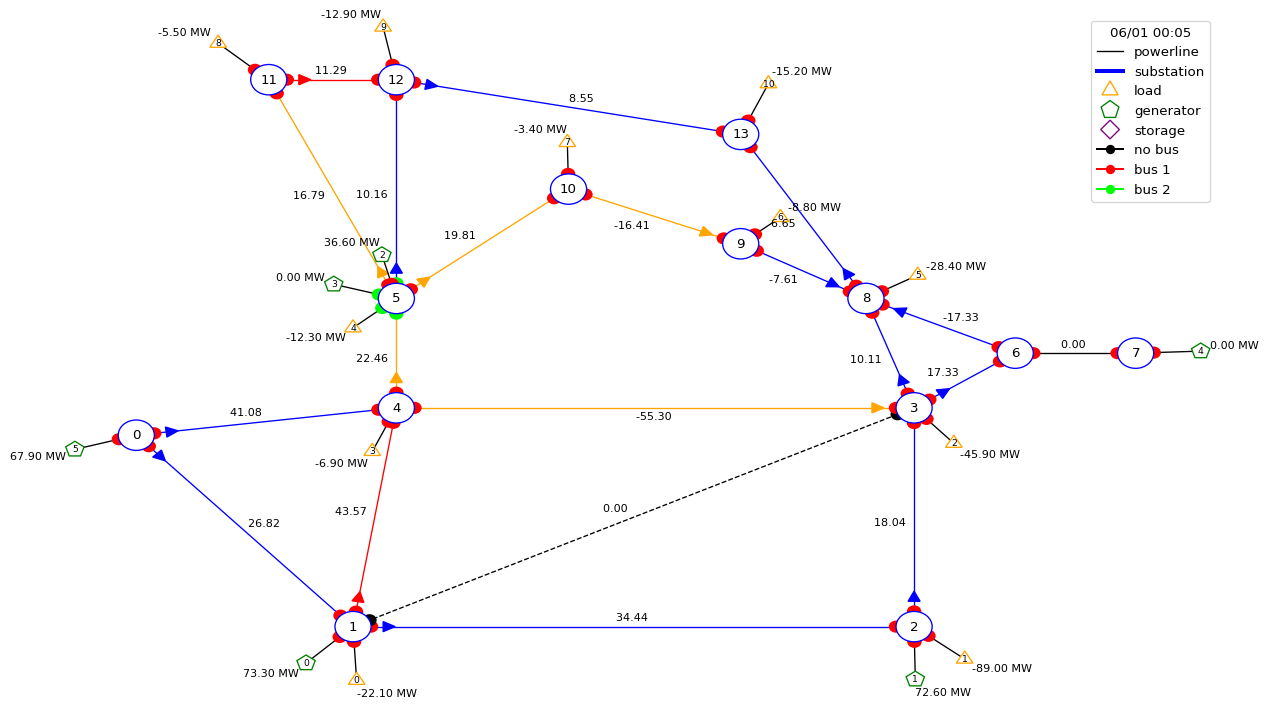

In [60]:
print("initial state with lines disconnected to reconnect")
fig = plot_helper.plot_obs(obs_start,line_info="p")
fig.show()

final state with lines reconnected


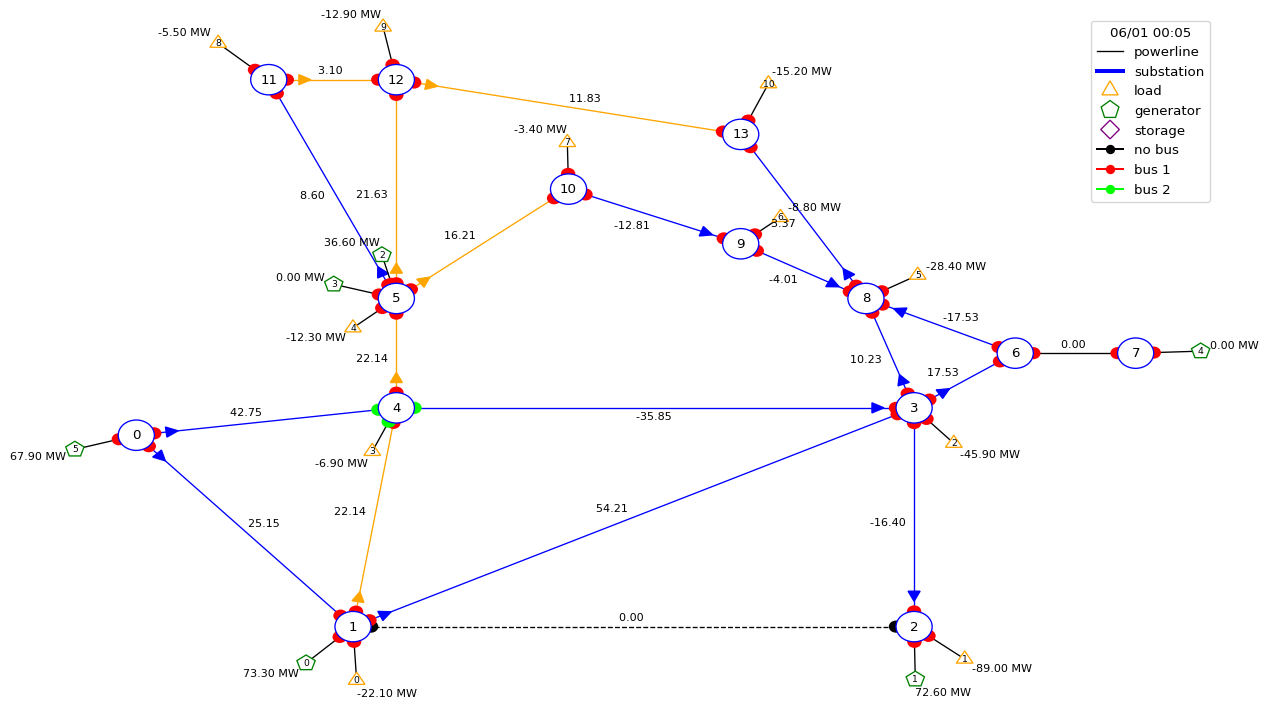

In [61]:
print("final state with lines reconnected")
fig = plot_helper.plot_obs(obs_target,line_info="p")
fig.show()

In [62]:
unitary_actions = [env.action_space(unitary_act) for unitary_act in unitary_action_list]


# running superposition theorem function
unit_act_observations = [obs_start.simulate(action, time_step=0)[0] for action in unitary_actions]


p_target_computed = compute_flows_superposition_theorem_from_unit_act_obs(idls_lines, idls_subs, obs_start, target_obs = None,
                                                              unit_act_observations = unit_act_observations,
                                                              check_obs_target=False,
                                                              decimal_digit_precision=decimal_accuracy)

assert (np.all((np.round(obs_target.p_or - p_target_computed, decimal_accuracy) == 0.0)))
p_target_computed


[[ 1.         -0.51426581 -0.01440201 -0.2271393 ]
 [ 0.29186649  1.         -0.01122368 -0.17701278]
 [-0.0644914   0.08855611  1.          0.3185595 ]
 [ 0.68395216 -0.93916462 -0.21421297  1.        ]]
[1. 1. 1. 1.]
computed betas: [1.54275193 0.69439906 0.79366581 0.76700004]


array([ 25.145487 ,  42.754528 ,   0.       ,  54.207916 ,  22.13757  ,
       -16.399994 , -35.854507 ,  16.209057 ,   8.596511 ,  21.632008 ,
        -4.0090556,   3.3714836, -12.809058 ,   3.0965087,  11.828517 ,
        17.531109 ,  10.231316 ,  22.137571 ,   0.       , -17.531109 ],
      dtype=float32)